<a href="https://colab.research.google.com/github/xu-pu/colab-notebooks/blob/master/sympy_double_pendulum_eom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Derive the Equations of Motion (EoM) of Double Pendulum

In [15]:
from sympy import *
init_printing()

Declare symbols

In [16]:
t, g, l1, l2, m1, m2, ddq1, ddq2 = symbols('t g l_1 l_2 m_1 m_2 \ddot{q_1} \ddot{q_2}')
q1 = Function('q_1')(t)
q2 = Function('q_2')(t)
dq1 = Function('\dot{q_1}')(t)
dq2 = Function('\dot{q_2}')(t)
t, g, l1, l2, m1, m2, q1, q2, dq1, dq2, ddq1, ddq2

Derive the positions and velocities of the centers of mass

In [17]:
x1 = l1 * sin(q1)
y1 = -l1 * cos(q1)
x2 = x1 + l2 * sin(q1+q2)
y2 = y1 - l2 * cos(q1+q2)

# substitution rules
rule = [(q1.diff(t),dq1),(q2.diff(t),dq2), (dq1.diff(t),ddq1), (dq2.diff(t),ddq2)]

dx1 = x1.diff(t).subs(rule)
dy1 = y1.diff(t).subs(rule)
dx2 = x2.diff(t).subs(rule)
dy2 = y2.diff(t).subs(rule)

Derive the Lagrangian $\mathcal{L} = T-V$

In [18]:
T1 = S.Half * m1 * (dx1**2 + dy1**2)
T2 = S.Half * m2 * (dx2**2 + dy2**2)

V1 = m1 * g * y1
V2 = m2 * g * y2

T = T1+T2
V = V1+V2

L = T-V
L = simplify(L)

Construct the Euler-Lagrange Equation
$$
\frac{d}{d t} \frac{\partial \mathcal{L}}{\partial \dot{q}}-\frac{\partial \mathcal{L}}{\partial q} = 0
$$

In [19]:
eq1 = L.diff(dq1).diff(t) - L.diff(q1)
eq1 = eq1.subs(rule)
eq1 = simplify(eq1)


eq2 = L.diff(dq2).diff(t) - L.diff(q2)
eq2 = eq2.subs(rule)
eq2 = simplify(eq2)

Solve for $\ddot{q}$

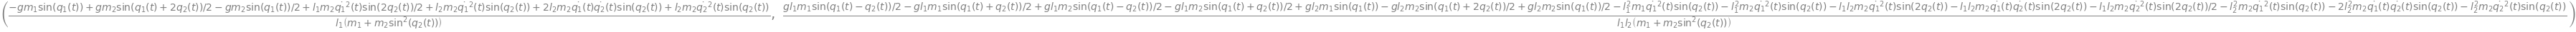

In [20]:
ans = solve((Eq(eq1,0),Eq(eq2,0)),(ddq1, ddq2))
sol_ddq1 = simplify(ans[ddq1])
sol_ddq2 = simplify(ans[ddq2])
sol_ddq1, sol_ddq2

# Construct the Equations of Motion (EoM) in Matrix Form

$$
\text{Equations of Motion:} \quad \ddot{q} = f(\theta, q,\dot{q})
$$

where $\theta$ is the system parameters $(m_1, m_2, l_1, l_2, g)$

In [21]:
q = MatrixSymbol('q',2,1)
dq = MatrixSymbol('dq',2,1)
ddq = MatrixSymbol('ddq',2,1)
theta = MatrixSymbol('theta',5,1)

# substitution rules
rules_eom = [
    (m1, theta[0,0]),
    (m2, theta[1,0]),
    (l1, theta[2,0]),
    (l2, theta[3,0]),
    (g,  theta[4,0]),
    (q1, q[0,0]),
    (q2, q[1,0]),
    (dq1, dq[0,0]),
    (dq2, dq[1,0])
    ]

# right hand side
eom_rhs = ImmutableMatrix([
   sol_ddq1.subs(rules_eom),
   sol_ddq2.subs(rules_eom)
])

eom = Eq(ddq,eom_rhs)  # equations of motion

# Code Generation for C/C++

In [22]:
from sympy.utilities.codegen import codegen
from IPython.display import display, Code

In [23]:
[(c_name, c_code), (h_name, c_header)] = codegen(
    ('double_pendulum_eom', eom), "C99", "double_pendulum", 
    argument_sequence=[theta, q, dq, ddq],
    header=False, empty=False
    )

In [24]:
display(Code(c_header, language='c'))

#ifndef PROJECT__DOUBLE_PENDULUM__H
#define PROJECT__DOUBLE_PENDULUM__H
void double_pendulum_eom(double *theta, double *q, double *dq, double *ddq);
#endif

In [25]:
display(Code(c_code, language='c'))

#include "double_pendulum.h"
#include <math.h>
void double_pendulum_eom(double *theta, double *q, double *dq, double *ddq) {
   ddq[0] = ((1.0/2.0)*sin(q[0] + 2*q[1])*theta[1]*theta[4] - sin(q[0])*theta[0]*theta[4] - 1.0/2.0*sin(q[0])*theta[1]*theta[4] + sin(q[1])*pow(dq[0], 2)*theta[1]*theta[3] + 2*sin(q[1])*dq[0]*dq[1]*theta[1]*theta[3] + sin(q[1])*pow(dq[1], 2)*theta[1]*theta[3] + (1.0/2.0)*sin(2*q[1])*pow(dq[0], 2)*theta[1]*theta[2])/((pow(sin(q[1]), 2)*theta[1] + theta[0])*theta[2]);
   ddq[1] = ((1.0/2.0)*sin(q[0] - q[1])*theta[0]*theta[2]*theta[4] + (1.0/2.0)*sin(q[0] - q[1])*theta[1]*theta[2]*theta[4] - 1.0/2.0*sin(q[0] + q[1])*theta[0]*theta[2]*theta[4] - 1.0/2.0*sin(q[0] + q[1])*theta[1]*theta[2]*theta[4] - 1.0/2.0*sin(q[0] + 2*q[1])*theta[1]*theta[3]*theta[4] + sin(q[0])*theta[0]*theta[3]*theta[4] + (1.0/2.0)*sin(q[0])*theta[1]*theta[3]*theta[4] - sin(q[1])*pow(dq[0], 2)*theta[0]*pow(theta[2], 2) - sin(q[1])*pow(dq[0], 2)*theta[1]*pow(theta[2], 2) - sin(q[1])*pow(dq[0], 2)*theta[1]*pow(theta[3], 2) - 2*sin(q[1])*dq[0]*dq[1]*theta[1]*pow(theta[3], 2) - sin(q[1])*pow(dq[1], 2)*theta[1]*pow(theta[3], 2) - sin(2*q[1])*pow(dq[0], 2)*theta[1]*theta[2]*theta[3] - sin(2*q[1])*dq[0]*dq[1]*theta[1]*theta[2]*theta[3] - 1.0/2.0*sin(2*q[1])*pow(dq[1], 2)*theta[1]*theta[2]*theta[3])/((pow(sin(q[1]), 2)*theta[1] + theta[0])*theta[2]*theta[3]);
}

# Code Generation for Python

In [26]:
f = lambdify([theta, q, dq], eom_rhs)